# Running Quantum Kernel SVM for Binary Classification on Qiskit #

Some set up information:

- Use Qiskit
- There are noise in data set
- No noise in simulators

Goals: When calculating quantum kernel (full circuit)
- Give Data of execution times 
- Give Data peak memory usage 
- Graph comparing accuracy between best quantum kernel in part 1 and classical SVM

## 1. Import libraries

1. Import classical libraries

In [ ]:
import sys
sys.path.append("../Help Function")

import make_data
import classical_algo

import time
import tracemalloc
import os
import csv 

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2. Import quantum libraries

In [20]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import Sampler

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Hybrid algorithm (classical SVM + quantum kernel)

From part 1 of exeriment, we will choose ZFeatureMap

In [21]:
def quantum_kernel(feature_dimension=2):
    feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=1, paulis=['Z'], alpha = 1.0)
        
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

    return quantum_kernel

1. Compute quantum kernel and training SVM using quantum kernel

In [22]:
def hybrid_algo(quantum_kernel, data_train, data_test, label_train, label_test):
    start = time.time()
    tracemalloc.start()

    kernel_train = quantum_kernel.evaluate(x_vec=data_train)
    kernel_test = quantum_kernel.evaluate(x_vec=data_test, y_vec=data_train)

    clf_quantum = SVC(kernel='precomputed')
    clf_quantum.fit(kernel_train, label_train)
    y_pred = clf_quantum.predict(kernel_test)
    acc_quantum = accuracy_score(label_test, y_pred)

    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time.time()

    return acc_quantum, end - start, peak

## 3. Run experiment

In [23]:
data_size = [10*i for i in range(2,11)]
kernel_option = ["Classical", "ZFeatureMap"]
results = []
rounds = 10

for size in data_size:
    accuracies, times, mems = (np.zeros(len(kernel_option)) for _ in range(3))

    for round in range(rounds):
        x, y = make_data.generate_xor_data(size, noise = 0.1)
        x_train, x_test, y_train, y_test = make_data.engineer_split_set(x,y)

        for idx, option in enumerate(kernel_option):
            if option == "Classical":
                acc, time_exec, peak_mem = classical_algo.classic(x_train, x_test, y_train, y_test)
            else:
                q_kernel = quantum_kernel(feature_dimension=2)
                acc, time_exec, peak_mem = hybrid_algo(q_kernel, x_train, x_test, y_train, y_test)

            print("\n{} encoding + classical SVM size {}: Round {}".format(option,size, round + 1))
            print("  Accuracy:", acc)
            print("  Execution time (sec):", time_exec)
            print(f"  Peak Memory Usage = {peak_mem/1024/1024:.4f} MB")

            accuracies[idx] += acc
            times[idx] += time_exec
            mems[idx] += peak_mem
    
    accuracies/=rounds
    times/=rounds
    mems/=rounds

    for idx, option in enumerate(kernel_option):
        results.append((size, option, accuracies[idx], times[idx], mems[idx]))


Classical encoding + classical SVM size 20: Round 1
  Accuracy: 0.8333333333333334
  Execution time (sec): 0.06934595108032227
  Peak Memory Usage = 20.84 MB

ZFeatureMap encoding + classical SVM size 20: Round 1
  Accuracy: 0.6666666666666666
  Execution time (sec): 0.8175125122070312
  Peak Memory Usage = 1.40 MB

Classical encoding + classical SVM size 20: Round 2
  Accuracy: 1.0
  Execution time (sec): 0.004264354705810547
  Peak Memory Usage = 0.01 MB

ZFeatureMap encoding + classical SVM size 20: Round 2
  Accuracy: 1.0
  Execution time (sec): 0.8300580978393555
  Peak Memory Usage = 1.53 MB

Classical encoding + classical SVM size 20: Round 3
  Accuracy: 0.6666666666666666
  Execution time (sec): 0.0
  Peak Memory Usage = 0.01 MB

ZFeatureMap encoding + classical SVM size 20: Round 3
  Accuracy: 0.5
  Execution time (sec): 0.8415384292602539
  Peak Memory Usage = 1.73 MB

Classical encoding + classical SVM size 20: Round 4
  Accuracy: 0.8333333333333334
  Execution time (sec): 

## 4. Graph

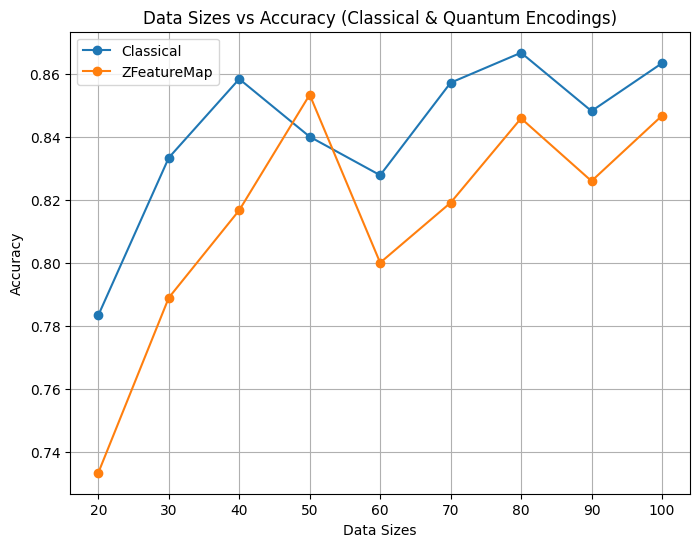

In [24]:
data_sizes, encodings, accuracies, times, mems = zip(*results)
unique_encodings = list(dict.fromkeys(encodings))  

plt.figure(figsize=(8,6))

for option in unique_encodings:
    x_vals = [s for s, e in zip(data_sizes, encodings) if e == option]
    y_vals = [a for a, e in zip(accuracies, encodings) if e == option]

    plt.plot(x_vals, y_vals, 'o-', label=option)

plt.xlabel("Data Sizes")
plt.ylabel("Accuracy")
plt.title("Data Sizes vs Accuracy (Classical & Quantum Encodings)")
plt.legend()
plt.grid(True)
plt.show()

## 5. Store data

In [ ]:
platform = "qiskit"
record_folder = "../Record Data"

os.makedirs(record_folder, exist_ok=True)

with open(os.path.join(record_folder, "time_executions.csv"), mode="a", newline="") as file:
    writer = csv.writer(file)
    for i, t in enumerate(times):
        if i%2 !=0: writer.writerow([platform, data_sizes[i], t])

with open(os.path.join(record_folder, "memory_usage.csv"), mode="a", newline="") as file:
    writer = csv.writer(file)
    for i, t in enumerate(mems):
        if i%2 !=0: writer.writerow([platform, data_sizes[i], t/1024/1024])